# Kv 1.4 parameter extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
write = False
paint = False
filebase = '/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf'
fileno, fileno2, fileno3, targetno = 36,37,None,39
savebase = filebase[:-4] % fileno + '-' + str(fileno3 or fileno2)
paramsfile = filebase[:-4] % targetno + '.params'
params = dict()
tres = 0.025 # Time of one sample in ms

In [3]:
rec = read_2channel_ATF(filebase % fileno)
rec2 = read_2channel_ATF(filebase % fileno2)
rec3 = read_2channel_ATF(filebase % fileno3) if fileno3 else None

## Sanity checks

To make sure we've got the right recordings, let's visualise the full trace stacks:

In [4]:
t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres
t3 = np.arange(len(rec3.voltage[0])) * tres if rec3 else None

def rawplot(ax, T, Y, ylabel=''):
    for y in Y:
        plt.plot(T, y)
    plt.xlabel('Time [ms]')
    plt.ylabel(ylabel)

if paint:
    fig = plt.figure(figsize=(15,10))
    fig.suptitle('Voltage clamp families')

    rawplot(plt.subplot(2,3,1), t, rec.voltage, 'Voltage [mV]')
    rawplot(plt.subplot(2,3,2), t2, rec2.voltage)
    if rec3: rawplot(plt.subplot(2,3,3), t3, rec3.voltage)

    rawplot(plt.subplot(2,3,4), t, rec.current, u'Current [μA]')
    rawplot(plt.subplot(2,3,5), t2, rec2.current)
    if rec3: rawplot(plt.subplot(2,3,6), t3, rec3.current)

    if write:
        fig.savefig(savebase + '.family.png')

Let's sanity check the step boundaries. The vertical lines should mark the exact beginning of the step and at least the end of the capacitive spike. Should the latter not coincide, the limits needs to be adjusted!

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5050, 44800)

# The true step time
rec_step_t0 = 4937

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec.current:
        plt.plot(I[4000:6000])

    plt.subplot(2,3,2)
    for I in rec.current:
        plt.plot(I[4927:4950])
    plt.axvline(rec_step_t0 - 4927)

    plt.subplot(2,3,3)
    for I in rec.current:
        plt.plot(I[rec_step_t0:rec_step_t0 + 5*(rec_limits[0]-rec_step_t0)])
    plt.axvline(rec_limits[0] - rec_step_t0)

    plt.subplot(2,1,2)
    for I in rec.current:
        plt.plot(I[rec_limits[0]:rec_limits[1]])

In [6]:
# The start and end of the step -- here, the first number is the true step time
rec2_limits = (1087, 40000)

# The cutoff for the tail current as used in the tail fitting procedure; this should mark the end of the capacitive spike
rec2_cut, dummy = get_tail_cut(rec2, rec2_limits[0])

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec2.current:
        plt.plot(I[800:1800])

    plt.subplot(2,3,2)
    for I in rec2.current:
        plt.plot(I[1070:1120])
    plt.axvline(rec2_limits[0] - 1070)

    plt.subplot(2,3,3)
    for I in rec2.current:
        plt.plot(I[rec2_limits[0]:rec2_limits[0] + 4*(rec2_cut-rec2_limits[0])])
    plt.axvline(rec2_cut-rec2_limits[0])
    plt.ylim(-2,4)

    plt.subplot(2,1,2)
    for I in rec2.current:
        plt.plot(I[rec2_cut:rec2_limits[1]])

Finally, a sanity check for the third (capacitance) recording, showing a step down and the subsequent step up:

In [7]:
# Index of the first step
rec3_offset = 322

# Step spec
rec3_stepdur = 2000
rec3_nsteps = 9

if rec3 and paint:
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    for V in rec3.voltage:
        plt.plot(t3[300:350], V[300:350])
        plt.plot(t3[300:350], V[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,2)
    for I in rec3.current:
        plt.plot(t3[300:350], I[300:350])
        plt.plot(t3[300:350], I[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,3)
    for V in rec3.voltage:
        plt.plot(V[rec3_offset:rec3_offset+rec3_stepdur])
        plt.plot(V[rec3_offset + (rec3_nsteps-1)*rec3_stepdur:rec3_offset + rec3_nsteps*rec3_stepdur])

## Measurements

### Leak current

In [8]:
if paint:
    fig, ax = plt.subplots()
else:
    ax = None

fit_leak(rec, params, ax, rec_limits)

if paint:
    plt.title('Leak conductance fit and activation I-V')
    if write:
        plt.savefig(savebase + '.leak_IV.png')

### Potassium current

In [9]:
tail_V = [np.median(V[rec2_limits[0]:rec2_limits[1]]) for V in rec2.voltage]

fit_tails_exp2(rec2, rec2_limits[0], rec2_limits[1], baseline = params['I_leak'](tail_V))

if paint:
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plot_tail_fit_exp2(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

    plt.subplot(1,2,2)
    plot_tail_fit_exp2(rec2, params, rec2_limits[0] - 20, 6000, tres, range(0, len(rec2.tails), 1))

    fig.suptitle('Tail current fits')
    if write:
        fig.savefig(savebase + '.tail_fits.png')

analysis_helpers.py:100: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:100: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


Trace 8 truncated fast tau 12.39594796487387


In [10]:
tail_t0 = [exp2_decay(0, rec2.pdecay[i]) for i in range(len(rec2.tails))]

included = linear_exclude_outliers(rec2.tail_voltages, tail_t0)
tail_I = np.array(tail_t0)[included]
tail_V = np.array(rec2.tail_voltages)[included]

fit_IV(tail_I, tail_V, params, 'K')

if paint:
    fig, ax = plt.subplots()
    IVplot(tail_I, tail_V, ax)

    tail_plot_V = np.array([-120, -40])
    ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

    ax.set_title('Potassium fit and tail current I-V')
    if write:
        plt.savefig(savebase + '.tail_IV.png')

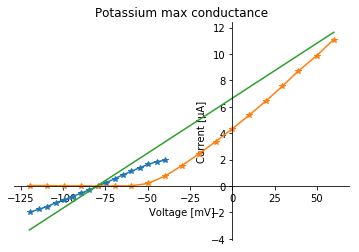

In [11]:
fig, ax = plt.subplots()
IVplot(tail_I, tail_V, ax)

median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
peak_currents = [np.max(I[rec_limits[0]:rec_limits[1]]) - params['I_leak'](V)
                 for I,V in zip(rec.current, median_voltages)]
IVplot(peak_currents, median_voltages, ax)

params['g_K'] = 1.05*peak_currents[-1] / (median_voltages[-1] - params['E_K'])

tail_plot_V = np.array([-120,60])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

ax.set_title('Potassium max conductance')
if paint and write:
    plt.savefig(savebase + '.gK.png')

### Capacitance

In [12]:
if rec3: params['C'] = fit_capacitance(rec3, tres, rec3_offset, rec3_stepdur, rec3_nsteps)

In [13]:
# RTDO accounts in mV, nA, μS and is not unit-aware
params_rtdo = params.copy()
params_rtdo['g_leak'] *= 1e3
params_rtdo['g_K'] *= 1e3

pstr = '\
gl:\t%(g_leak)f μS\n\
El:\t%(E_leak)f mV\n\
gA:\t%(g_K)f μS\n\
EK:\t%(E_K)f mV' % params_rtdo

if rec3: pstr += '\nC:\t%(C)f nF' % params_rtdo

print pstr

if write:
    f = open(paramsfile, 'w')
    f.write(pstr)
    f.close()

gl:	2.526743 μS
El:	-28.738655 mV
gA:	83.230559 μS
EK:	-80.001965 mV
C:	176.326881 nF


### Remaining current at Kv2.1 peak time (test for mixed recordings)

In [14]:
peaktest = False
if peaktest:
    # From Kv21, 2018_05_03_19-21, good enough for a rough approximation:
    peaktimes = lambda V: -386.960332 * V + 26923.448908
    remaining_fraction = [I[rec_step_t0+int(peaktimes(V))] / peak
                          for peak,I,V in zip(peak_currents, rec.current, median_voltages)
                          if V > -20]
    med_volt = median_voltages[-len(remaining_fraction):]
    plt.plot(med_volt, remaining_fraction, '-*')
    
    expo = lambda p,x: p[0]*np.exp(p[1]*x) + p[2]
    ret = scipy.optimize.least_squares(lambda p, x, y: (expo(p,x) - y), (0.05,0.1, 0.02),
                                       args = (np.array(med_volt), np.array(remaining_fraction)), method='lm')
    
    Vplot = np.arange(-20,60)
    plt.plot(Vplot, expo(ret.x, Vplot))
    
    print 'fraction of remaining current = %f * exp(%f * V) + %f' % (ret.x[0], ret.x[1], ret.x[2])

Solving the inverse problem like...

In [15]:
findpeaktimes = False
if findpeaktimes:
    median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
    peak_currents = [np.max(I[rec_limits[0]:rec_limits[1]]) - params['I_leak'](V)
                     for I,V in zip(rec.current, median_voltages)]
    peak_current_t = [np.argmax(I[rec_limits[0]:rec_limits[1]]) + rec_limits[0]-rec_step_t0 for I in rec.current]
    
    # Use reliable peaks only
    gmax = max(peak_currents)
    for i in range(len(peak_currents)-1, 0, -1):
        if peak_currents[i] < 0.1 * gmax:
            time_fit_from = i+1
            break
    
    fig, ax = plt.subplots()
    IVplot(peak_current_t[time_fit_from:], median_voltages[time_fit_from:], ax,
           Ilabel = 'Time after step (*%f ms)' % tres)
    
    # Not quite linear, so try exponential:
    expo = lambda p,x: p[0]*np.exp(p[1]*x) + p[2]
    X, Y = np.array(median_voltages[time_fit_from:]), np.array(peak_current_t[time_fit_from:])
    ret = scipy.optimize.least_squares(lambda p, x, y: (expo(p,x) - y), (150, -0.1, 200),
                                       args = (X, Y), method='lm')
    Vplot = np.arange(-30,60)
    plt.plot(Vplot, expo(ret.x, Vplot))
    
    print 't_peak [samples] = %f * exp(%f * V) + %f' % (ret.x[0], ret.x[1], ret.x[2])